### Marcenko-Pastur Distribution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def marcenko_pastur_prob_distribution(var, q, pts) :
    eMin, eMax = var * (1 - (1.0 / q) ** 0.5) ** 2, var * (1 + (1.0 / q) ** 0.5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** 0.5
    pdf = pd.Series(pdf, index = eVal)
    return pdf

In [2]:
from sklearn.neighbors import KernelDensity

def getPCA(matrix) :
    eVal, eVec = np.linalg.eig(matrix)
    indeces = eVal.argsort()[::-1]
    eVal, eVec = eVal[indeces], eVec[:, indeces]
    eVal = np.diagflat(eVal)
    return eVal, eVec

def fit_kde(obs, bWidth = 0.25, kernel = 'gaussian', x = None) :
    if len(obs.shape) == 1: obs = obs.reshape(-1, 1)
    kde = KernelDensity(
        kernel = kernel, 
        bandwidth = bWidth
    ).fit(obs)

    if x is None: x = np.unique(obs).reshape(-1, 1)

    if len(x.shape) == 1: x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(
        np.exp(logProb), 
        index = x.flatten()
    )
    return pdf

잡음만 존재하는 경험적 랜덤 행렬 분포의 고유값을 marcenko-pastur dist에 적합화한 경우

In [3]:
x = np.random.normal(size = (10000, 1000))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar = 0))
pdf0 = marcenko_pastur_prob_distribution(1.0, q = x.shape[0] / float(x.shape[1]), pts = 1000)
pdf1 = fit_kde(
    np.diag(eVal0),
    bWidth = .01
) # empirical prob. dist

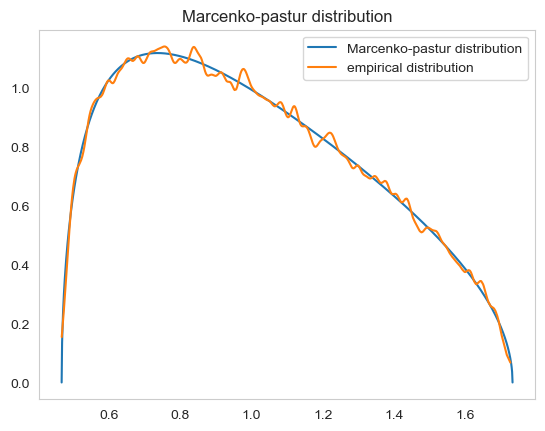

In [4]:
plt.plot(pdf0, label = 'Marcenko-pastur distribution')
plt.plot(pdf1, label = 'empirical distribution')
plt.legend()
plt.grid(False)
plt.title('Marcenko-pastur distribution')
plt.show()

signal이 존재하는 랜덤 행렬에서의 marcenko-pastur 분포

In [5]:
def get_random_covariance(nCols, nFacts) :
    w = np.random.normal(size = (nCols, nFacts))
    cov = np.dot(w, w.T)
    cov += np.diag(np.random.uniform(size = nCols))
    return cov

In [6]:
def covariance_to_correlation(cov) :
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1 # 수치 오차
    return corr

In [7]:
alpha = 0.995 # noise ratio
nCols = 1000
nFacts = 100
q = 10

cov = np.cov(
    np.random.normal(size = (nCols * q, nCols)),
    rowvar = 0
)
cov = alpha * cov + (1 - alpha) * get_random_covariance(nCols, nFacts) # noise + signal
corr0 = covariance_to_correlation(cov)
eVal0, eVec0 = getPCA(corr0)

신호가 있는 상태에서 marcenko-pastur dist 적합화를 진행하려면 다음과 같은 과정을 따라야 한다

In [8]:
def pdf_error(var, eVal, q, bWidth, pts = 1000, verbose = False) :
    var = var[0]
    pdf0 = marcenko_pastur_prob_distribution(var, q, pts)  # theoretical pdf
    pdf1 = fit_kde(eVal, bWidth, x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0) ** 2)
    if verbose : print("sse:" + str(sse))
    return sse

In [71]:
from scipy.optimize import minimize
def find_max_eval(eVal, q, bWidth, verbose = False) :
    out = minimize(
        lambda *x: pdf_error(*x), 
        x0 = np.array(0.5), 
        args = (eVal, q, bWidth), 
        bounds = ((1E-5, 1 - 1E-5),)
    )
    
    if verbose : print("found errPDFs" + str(out['x'][0]))
    
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1. / q) ** .5) ** 2
    
    return eMax, var

In [10]:
eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

found errPDFs0.6765789507553306


In [11]:
pdf0 = marcenko_pastur_prob_distribution(
    var0, 
    q = x.shape[0]/float(x.shape[1]), 
    pts = 1000
)

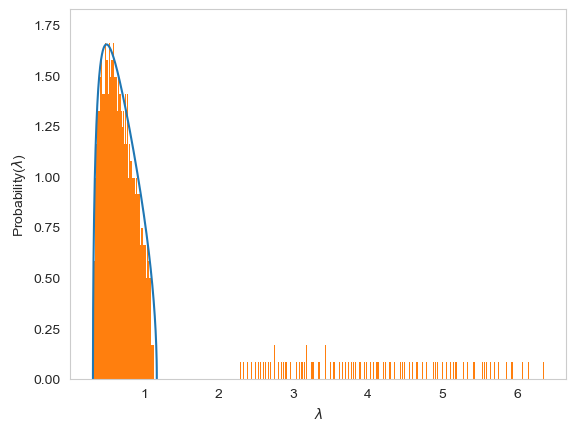

In [12]:
plt.plot(pdf0, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal0), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.show()

#### Denoising

상수 잔차 고유값을 이용한 잡음 제거

In [13]:
def denoise_constant_eigen_value(eVal, eVec, nFacts):
    """
    denoising to fix random eigen value from correlation matrix
    """
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)
    eVal_ = np.diag(eVal_)
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = covariance_to_correlation(corr1)
    return corr1

def denoise_target_shrinkage(eVal, eVec, nFacts, alpha = 0) :
    """
    denoising to use target shrinkage method from correlation matrix
    """
    eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:, :nFacts]
    eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:, nFacts:]
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)
    corr2 = corr0 + alpha * corr1 + (1 - alpha) * np.diag(np.diag(corr1))
    return corr2

In [14]:
corr1 = denoise_constant_eigen_value(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

<Axes: >

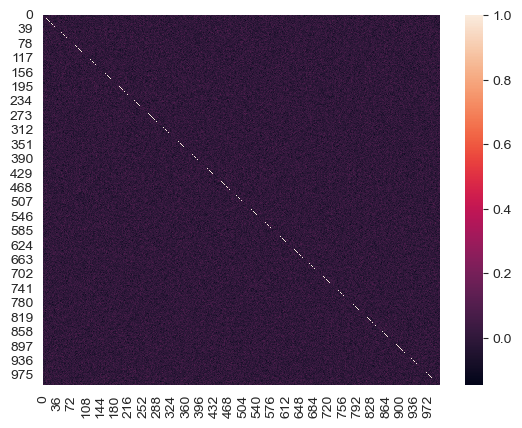

In [16]:
import seaborn as sns
sns.heatmap(corr1) # 상수 고유값 방법을 통한 잡음 제거

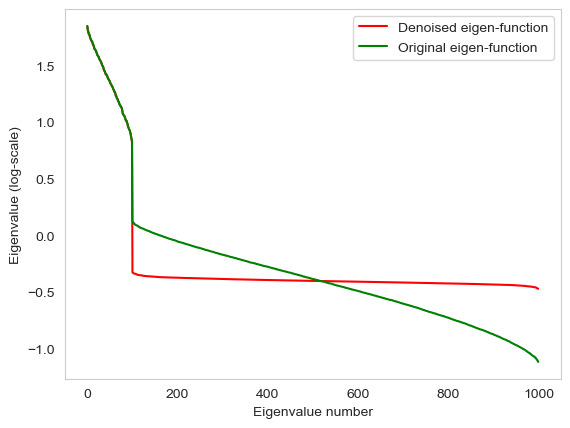

In [24]:
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.grid(False)
plt.show()

**Target Shrinkage**

타깃 축소 방법을 통한 잡음 제거.

$$
C_1 = W_L\Lambda_LW_L^\prime + \alpha W_R \Lambda_R W_R^\prime +(1 - \alpha) \mathrm{diag}[W_R\Lambda_RW_R^\prime]
$$

In [26]:
corr1 = denoise_target_shrinkage(eVal0, eVec0, nFacts0, alpha = 0.5)
eVal1, eVec1 = getPCA(corr1)

<Axes: >

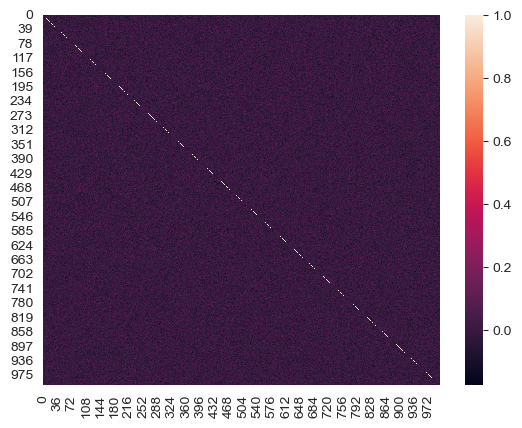

In [27]:
import seaborn as sns
sns.heatmap(corr1) # 타깃 축소를 이용한 잡음 제거

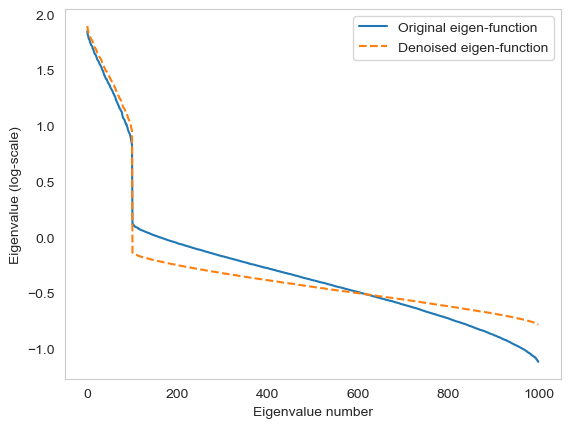

In [30]:
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), label="Original eigen-function")
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), label="Denoised eigen-function", ls = '--')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.grid(False)
plt.show()

#### Detoning

금융 상관 행렬은 일반적으로 시장 요소를 포함한다. 시장 구성 요소는 로딩 $W_{n,1} \approx N^{-\frac{1}{2}}, n = 1, \dots, N$를 가진 첫 번째 고유 벡터로 특징 지어진다. 따라서, 시장 요소는 공분산ㄴ 행렬의 모든 항목에 영향을 미친다.

clustering 응용의 맥락에서, 이러한 시장 요소가 존재하는 경우 이를 제거하는 것이 유용하다. 그 이유는 알고리즘이 군집 간 차이를 갖고자 애쓸 것이므로 강력한 시장 구성 요소를 가진 상관 행렬을 군집화하는것이 더 어렵기 때문이다. 시장요소를 제거해서 그 상관관계의 더 많은 부분을 유가증권의 특정 부분 집합에 영향을 미치는 요소들에 의해 설명될 수 있도록 한다. 이는 우리가 다른 소리를 듣지 못하게 하는 큰 소리를 제거하는 것과 비슷하다.

Detoning은 회귀 분석에서 베타 조정 수익률을 계산하는 것과 유사한 주성분 분석이다.

잡음이 제거된 상관 행렬 $C_1$에서 시장 요소를 제거해 주음 제거된 상관 행렬을 형성할 수 있다.

$$
\tilde C_2 = C_1 - W_M \Lambda_M W_M^\prime = W_D \Lambda_D W_D^\prime
$$

$$
C_2 = \tilde C_2 \left[ 
\left( \mathrm{diag}[\tilde C_2] ^{\frac{1}{2}}\right)
\left( \mathrm{diag}[\tilde C_2] ^{\frac{1}{2}}^\prime\right)
\right]
$$

In [32]:
def signal_detoning(corr, eigenvalues, eigenvectors, market_component = 1):
    eigenvalues_mark = eigenvalues[:market_component, :market_component]
    eigenvectors_mark = eigenvectors[:, :market_component]

    corr_mark = np.dot(eigenvectors_mark, eigenvalues_mark).dot(eigenvectors_mark.T)
    corr = corr - corr_mark
    corr = covariance_to_correlation(corr)
    return corr

In [38]:
corr_detoned_denoised = signal_detoning(corr0, eVal0, eVec0)

eVal1_detoned, eVec1_detoned = getPCA(corr_detoned_denoised)
detoned_eigenvalue = np.diag(eVal1_detoned)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)

/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_16435/587732260.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(range(0, len(detoned_eigenvalue)), np.log(detoned_eigenvalue), label="Detoned eigen-function")


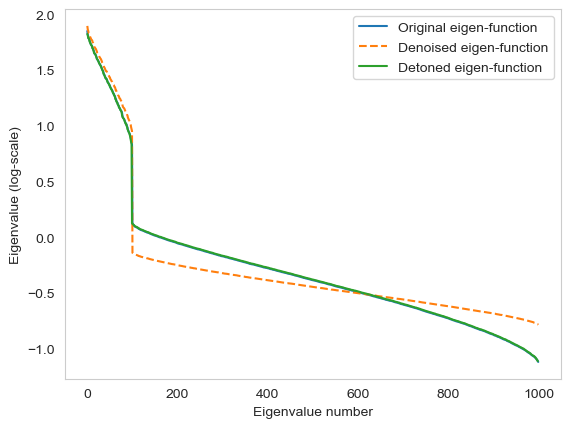

In [39]:
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), label="Original eigen-function")
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), label="Denoised eigen-function", ls = '--')
plt.plot(range(0, len(detoned_eigenvalue)), np.log(detoned_eigenvalue), label="Detoned eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.grid(False)
plt.show()

In [43]:
eMax1, var1 = find_max_eval(np.diag(eVal1_detoned), q, bWidth = 0.01)
nFacts1 = eVal1_detoned.shape[0] - np.diag(eVal1_detoned)[::-1].searchsorted(eMax1)

found errPDFs0.6809379090238501


In [44]:
pdf1 = marcenko_pastur_prob_distribution(
    var1, 
    q = x.shape[0]/float(x.shape[1]), 
    pts = 1000
)

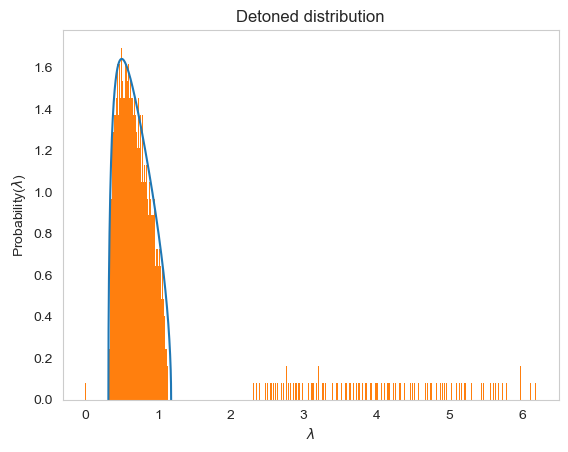

In [49]:
plt.plot(pdf1, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal1_detoned), density = True, bins = 500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.title("Detoned distribution")
plt.show()

### Montecarlo Simulation

몬테카를로 시뮬레이션을 통해 잡음 제거의 효과를 확인해 보자


#### Minimal Variacne Optimization Portfolio

In [50]:
from scipy.linalg import block_diag

def formBlockMatrix(nBlocks, bSize, bCorr): 
    block = np.ones((bSize, bSize)) * bCorr 
    block[range(bSize), range(bSize)] = 1 
    corr = block_diag(*([block] * nBlocks)) 
    return corr

def correlation_to_covariance(corr, std): 
    cov = corr * np.outer(std, std) 
    return cov

def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0 = corr0[cols].loc[cols].copy(deep = True) 
    std0 = np.random.uniform(.05, .2, corr0.shape[0]) 
    cov0 = correlation_to_covariance(corr0, std0) 
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1, 1) 
    return mu0, cov0

In [51]:
from sklearn.covariance import LedoitWolf 
nBlocks, bSize, bCorr = 10, 50, .5
np.random.seed(42)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

In [53]:
def empirical_covariance_matrix(mu0, cov0, nObs, shrink = False): 
    x = np.random.multivariate_normal(mu0.flatten(),cov0,size = nObs) 
    mu1 = x.mean(axis = 0).reshape(-1,1)
    if shrink: cov1 = LedoitWolf().fit(x).covariance_ 
    else: cov1 = np.cov(x, rowvar = 0)
    return mu1,cov1

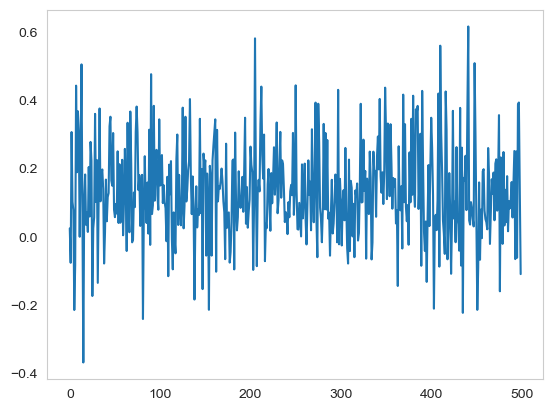

In [57]:
plt.plot(mu0)
plt.grid(False)
plt.show()

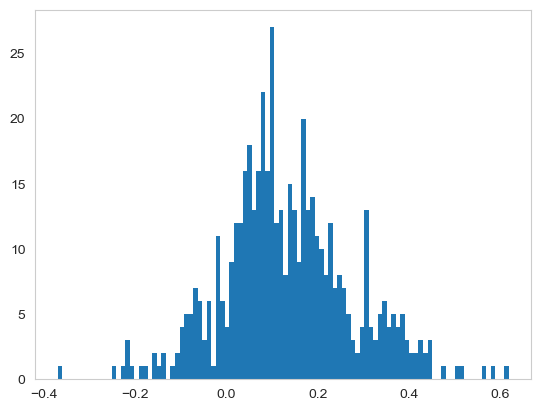

In [61]:
plt.hist(mu0, bins = 100, edgecolor = 'none')
plt.grid(False)
plt.show()

In [65]:
def deNoiseCov(cov0, q, bWidth):
    corr0 = covariance_to_correlation(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoise_constant_eigen_value(eVal0, eVec0, nFacts0)  # denoising by constant residual eigenvalue method
    cov1 = correlation_to_covariance(corr1, np.diag(cov0) ** .5)
    return cov1

In [67]:
nObs = 5
mu1, cov1 = empirical_covariance_matrix(mu0, cov0, nObs)

<Axes: >

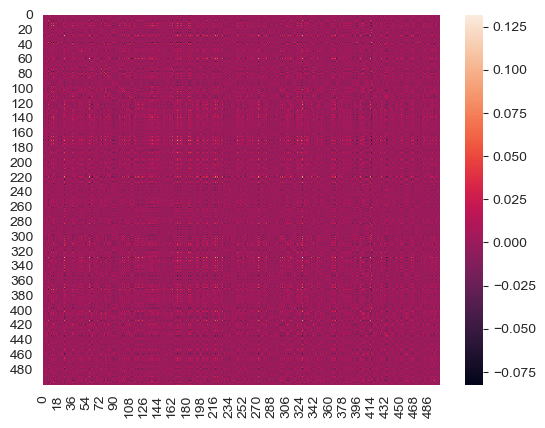

In [68]:
sns.heatmap(cov1)

<Axes: >

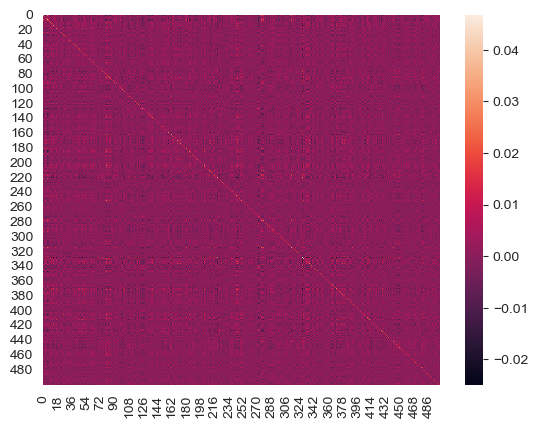

In [69]:
mu2, cov2 = empirical_covariance_matrix(mu0, cov0, nObs, shrink = True)
sns.heatmap(cov2) # Ledoit-Wolf shrinkage

Portfolio Optimization 

In [76]:
from tqdm import tqdm

def optPort(cov, mu = None): 
    inv = np.linalg.inv(cov) 
    ones = np.ones(shape = (inv.shape[0],1)) 
    if mu is None : mu = ones
    w = np.dot(inv,mu) 
    w /= np.dot(ones.T,w) 
    return w

In [77]:
nObs = 1000
nTrials = 100
bWidth = 0.01
shrink = False
minVarPortf = False

w1 = pd.DataFrame(
    columns = range(cov0.shape[0]), 
    index = range(nTrials),
    dtype = float
) 
w1_d = w1.copy(deep = True)
np.random.seed(42)
for i in tqdm(range(nTrials)):
    mu1, cov1 = empirical_covariance_matrix(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf: mu1 = None
    cov1_d = deNoiseCov(cov1, nObs * 1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


In [78]:
w0 = optPort(cov0, None if minVarPortf else mu0) 
w0 = np.repeat(w0.T, w1.shape[0], axis = 0) 
rmsd = np.mean((w1 - w0).values.flatten() ** 2) ** .5
rmsd_d = np.mean((w1_d - w0).values.flatten() ** 2) ** .5 # denoised
print(rmsd, rmsd_d)

0.46630277414397864 0.032167408953521576


In [79]:
minVarPortf = True

w1 = pd.DataFrame(
    columns = range(cov0.shape[0]), 
    index = range(nTrials), 
    dtype = float
) 
w1_d = w1.copy(deep = True)
np.random.seed(42)
for i in range(nTrials):
    mu1, cov1 = empirical_covariance_matrix(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf : mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

In [80]:
w0 = optPort(cov0, None if minVarPortf else mu0) 
w0 = np.repeat(w0.T, w1.shape[0],axis = 0) 
rmsd = np.mean((w1 - w0).values.flatten()**2)**.5
rmsd_d = np.mean((w1_d - w0).values.flatten()**2)**.5 # denoised
print(rmsd, rmsd_d)

0.005045849404333227 0.0011767403712115326


denoising된 포트폴리오의 RMSE가 현저히 낮은 것을 알 수 있다

In [81]:
import warnings 
warnings.filterwarnings('ignore')

stock_list = pd.read_csv('stock_list.csv', index_col = 0)

In [82]:
code = stock_list['Code'][stock_list['Code'].str[-1] == '0'][:500]

### Empirical Data

실제 금융 데이터를 활용해 shrinkage가 현실적인지 확인한다

In [83]:
import pandas_datareader as pdr
import datetime

data = pd.DataFrame()

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2024, 3, 7)

for i in code :
    data = pd.concat(
        [data, 
        pdr.DataReader(i, "naver", start_date, end_date)['Close']], 
        axis = 1
    )
data.columns = code

In [85]:
data.dropna(inplace = True, axis = 1)

In [88]:
data = data.astype(int)

<Axes: xlabel='Code', ylabel='Code'>

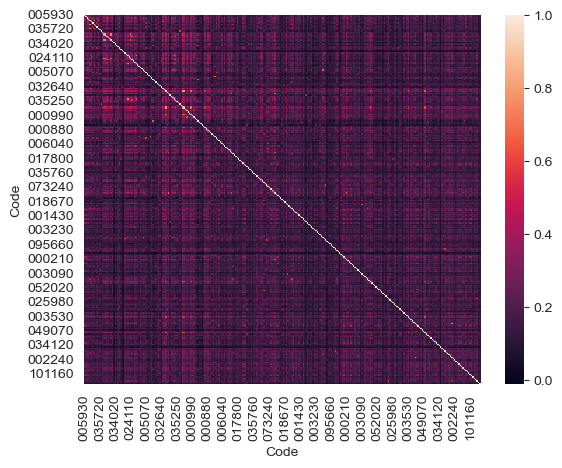

In [92]:
sns.heatmap(data.pct_change().corr())

In [93]:
eVal0, eVec0 = getPCA(data.pct_change().corr())

In [94]:
eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [95]:
pdf0 = marcenko_pastur_prob_distribution(
    var0, 
    q = x.shape[0]/float(x.shape[1]), 
    pts = 1000
)

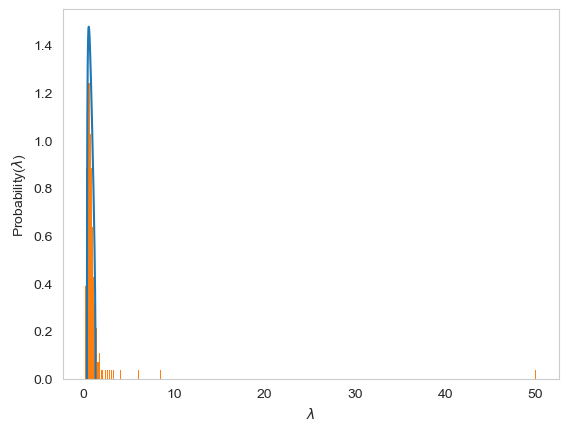

In [98]:
plt.plot(pdf0, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal0), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.show()

In [99]:
corr1 = denoise_constant_eigen_value(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

In [115]:
eMax1, var1 = find_max_eval(np.diag(eVal1), q, bWidth = 0.01)
nFacts1 = eVal1.shape[0] - np.diag(eVal1)[::-1].searchsorted(eMax1)

In [116]:
pdf1 = marcenko_pastur_prob_distribution(
    var1, 
    q = x.shape[0] / float(x.shape[1]), 
    pts = 1000
)

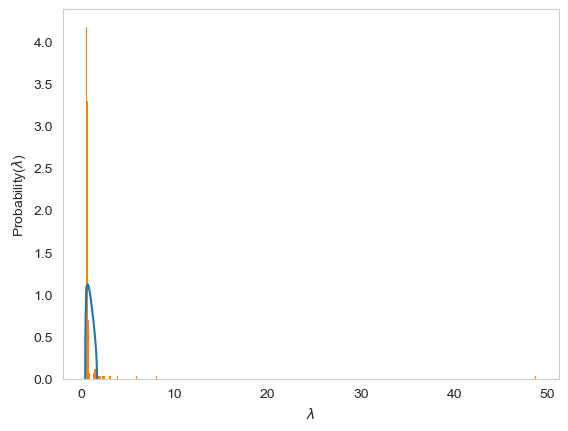

In [117]:
plt.plot(pdf1, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal1), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.show()

<Axes: >

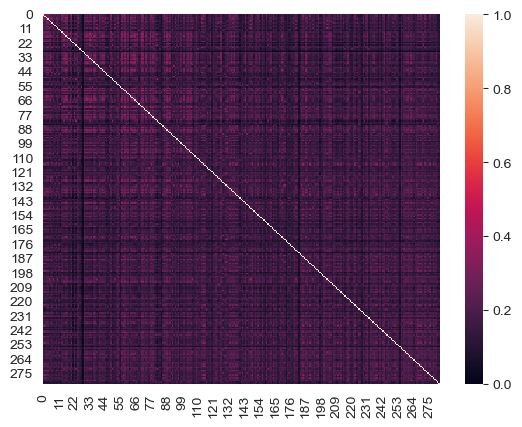

In [119]:
sns.heatmap(corr1)

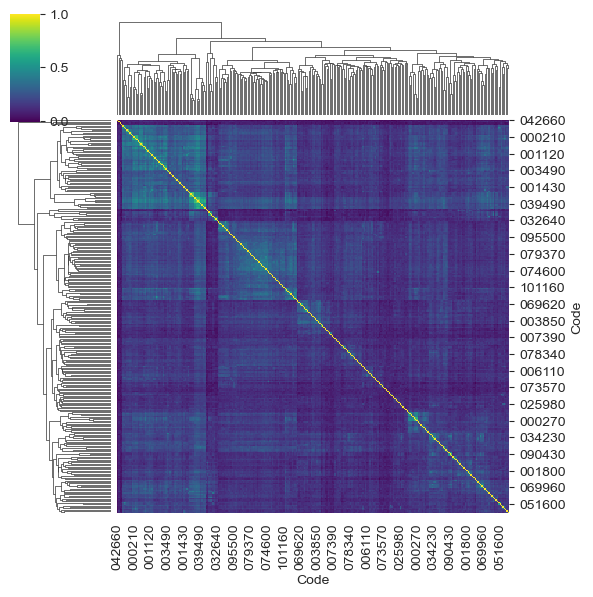

In [124]:
sns.clustermap(
    data.pct_change().corr(),
    figsize = (6, 6),
    cmap = 'viridis'
)

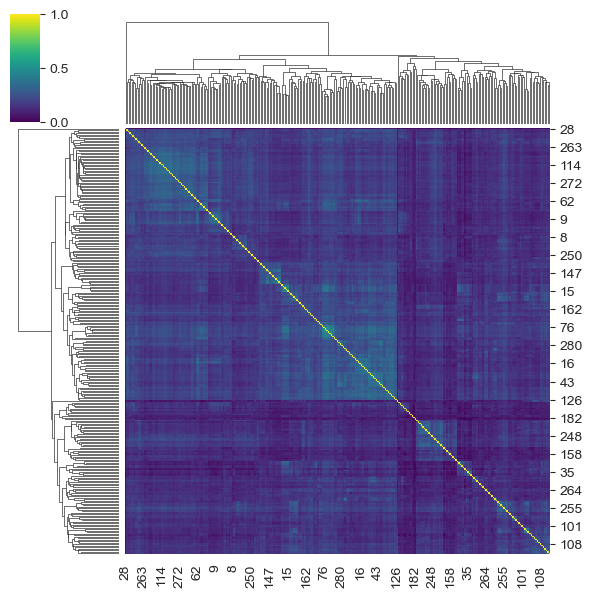

In [125]:
sns.clustermap(
    corr1,
    figsize = (6, 6),
    cmap = 'viridis'
)